# Customer Experience Analysis at E-commerce company
The purpose of this analysis is to discover the factors that influence review score most, as well as overall business indexes. The dataset has been provided by a Brazilian online e-commerce company, Olist, and has been accumulated over the past 2 years from Sep 2016 to Sep 2018.

## Table of Contents
1. Data Preprocessing
2. Exploratory Data Analysis
3. Review Reaction Prediction & Feature Importance
3. Conclusion & Action Plan

## 1. Data Preprocessing

In [1836]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [1837]:
items = pd.read_csv("olist_order_items_dataset.csv")
review = pd.read_csv("olist_order_reviews_dataset.csv")
product = pd.read_csv("olist_products_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
payment = pd.read_csv("olist_order_payments_dataset.csv")
translate = pd.read_csv("product_category_name_translation.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")

In [1838]:
df = pd.merge(review, items, on= 'order_id', how = 'inner')
df= df.merge(product, on = 'product_id', how = 'inner')
df= df.merge(orders, on = 'order_id', how = 'inner')
df= df.merge(payment, on = 'order_id', how = 'inner')
df = df.merge(customers, on = 'customer_id', how = 'inner')
df = pd.merge(df, sellers, on = 'seller_id', how = 'inner')
df.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,...,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,14600,sao joaquim da barra,SP
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,14600,sao joaquim da barra,SP
2,e2655da8bccce2ddc2f43cc2c80d24f3,19721d59a9764437477eff0730b48665,5,NaN,NaN,2018-04-10 00:00:00,2018-04-11 11:30:43,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,credit_card,3,205.26,059ba8400bf965adf606ecc7ef3396e9,95860,taquari,RS,14600,sao joaquim da barra,SP
3,cb18f53b563f0bdeb76be0376ddd6b6a,efd626e6a12a82d76e456e34093f8356,5,NaN,NaN,2017-12-28 00:00:00,2017-12-30 12:07:50,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,credit_card,2,202.05,62a25a159f9fd2ab7c882d9407f49aa9,36500,uba,MG,14600,sao joaquim da barra,SP
4,5fdb2ed7aa0f1b1c9642175b302e38af,b0bc656fed47584c160f8cff2d7b8bbd,5,NaN,NaN,2018-03-17 00:00:00,2018-03-17 17:36:27,1,1acb18fc869c5489d5f76abcd681165e,6d803cb79cc31c41c4c789a75933b3c7,...,credit_card,1,306.40,86243f3e50e3b844b1d7bd850c4d2623,38412,uberlandia,MG,14600,sao joaquim da barra,SP


In [1839]:
# replacing Portuguese category names with English names

df = df.join(translate.set_index('product_category_name')['product_category_name_english'], on = 'product_category_name')
df.drop(columns = 'product_category_name', inplace = True)
df.rename({'product_category_name_english': 'product_category'},axis= "columns", inplace = True)
df['product_category'].sample(3)

87532    telephony
85836     pet_shop
72576    telephony
Name: product_category, dtype: object

In [1840]:
# checking for datatypes - datetime & category

dtime = ['review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
         'order_estimated_delivery_date', 'order_approved_at']

for d in dtime:
    df[d] = df[d].astype('datetime64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      118315 non-null  object        
 1   order_id                       118315 non-null  object        
 2   review_score                   118315 non-null  int64         
 3   review_comment_title           14089 non-null   object        
 4   review_comment_message         50665 non-null   object        
 5   review_creation_date           118315 non-null  datetime64[ns]
 6   review_answer_timestamp        118315 non-null  datetime64[ns]
 7   order_item_id                  118315 non-null  int64         
 8   product_id                     118315 non-null  object        
 9   seller_id                      118315 non-null  object        
 10  shipping_limit_date            118315 non-null  object        
 11  

In [1841]:
# checking for missing values in all columns

df['product_category'] = df['product_category'].fillna("no_data")

avg = ['product_description_lenght', 'product_photos_qty', 'product_name_lenght','product_weight_g', 'product_height_cm', 'product_length_cm', 'product_width_cm']
review = ['review_comment_title', 'review_comment_message']

for i in avg:
    df[i].fillna(df[i].mean(), inplace = True)
        
for a in review:
    df[a].fillna('NA', inplace= True)

# handling missing values

df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)
df["order_estimated_delivery_date"].fillna(df["order_delivered_customer_date"], inplace=True)
df['order_delivered_carrier_date'].fillna(df['order_approved_at'], inplace = True)
df['order_delivered_customer_date'].fillna(df["order_estimated_delivery_date"], inplace = True)

df.isna().sum()

review_id                        0
order_id                         0
review_score                     0
review_comment_title             0
review_comment_message           0
review_creation_date             0
review_answer_timestamp          0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_sequential               0
payment_type        

In [1842]:
# removing duplicates

df.drop_duplicates(subset = {'order_id', 'product_id', 'order_item_id'}, inplace = True)

### Exploratory Data Analysis

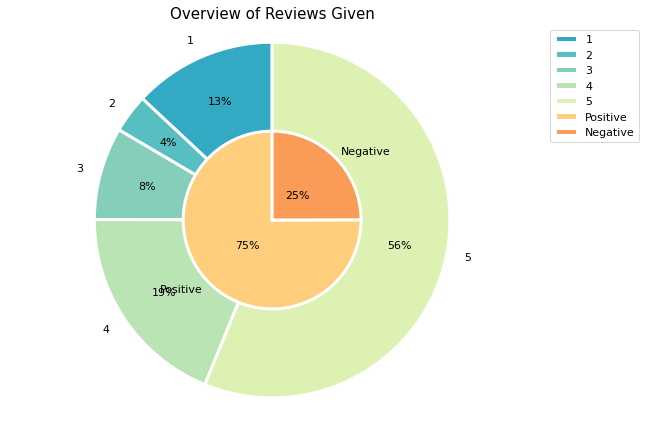

In [1843]:
# Let's first divide positive reviews with score higher than 3, and negative reviews with score lower than 3.

def division(x):
    if x<=3:
        return "1"
    else: return "0"

df['reaction'] = df['review_score'].apply(division)
df['reaction'] =df['reaction'].astype(int)

palette = sns.color_palette("Paired", 2)
palette_o = sns.color_palette("YlGnBu", 10)
palette_i = sns.color_palette("Spectral",10)

outer = [palette_o[5],palette_o[4],palette_o[3],palette_o[2], palette_o[1]]
inner = [palette_i[3], palette_i[2]]
color_list = [palette[0], palette[1]]

number = df['review_score'].value_counts().sort_index(ascending=True).values
labels_2 = ['1','2', '3', '4', '5']
x2 = [number[0],number[1], number[2], number[3], number[4]]
labels_3 =['Positive','Negative']
x3 = [df['reaction'].value_counts().values[0],df['reaction'].value_counts().values[1]]

plt.figure(figsize=(9,6))
plt.pie(x2,startangle=90, labels = labels_2, pctdistance =0.73,colors=outer,textprops ={'fontsize':11},
        wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" }, autopct = '%1.0f%%',radius= 0.4)
plt.pie(x3,startangle=90, labels = labels_3, pctdistance =0.4,colors=inner,textprops ={'fontsize':11},
        wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" }, autopct = '%1.0f%%',radius= 0.2 )
plt.axis('equal') 
plt.legend(loc=1, bbox_to_anchor=(0.8, 0., 0.4, 1), fontsize =11)
plt.title("Overview of Reviews Given", size = 15)
plt.tight_layout();

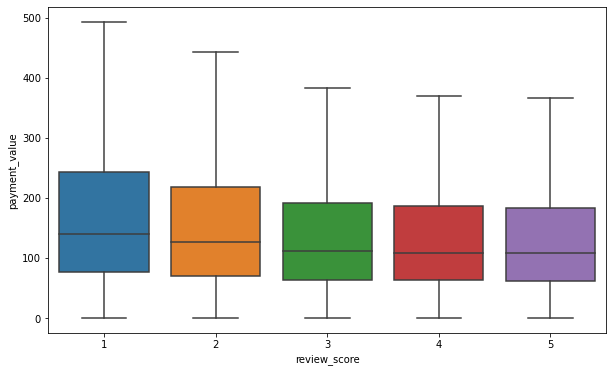

In [1844]:
plt.figure(figsize = (10,6))
sns.boxplot(df['review_score'], df['payment_value'], showfliers=False);

In [1845]:
df.groupby('review_score')['product_description_lenght'].agg(['mean', 'std'])

,mean,std
review_score,,
1,778.505136,653.949742
2,738.706227,602.899209
3,771.605810,637.862873
4,794.622211,641.463678
5,793.214372,651.922058


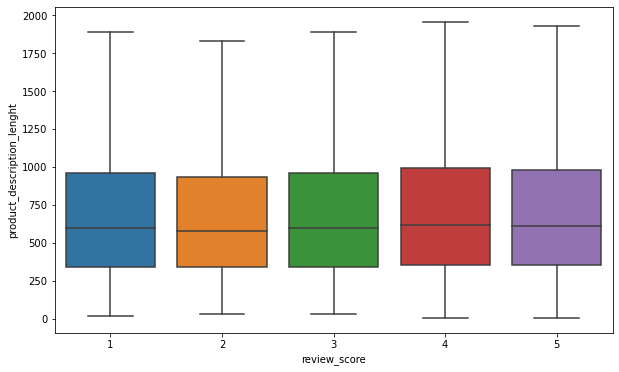

In [1846]:
plt.figure(figsize = (10,6))
sns.boxplot(df['review_score'], df['product_description_lenght'], showfliers=False);

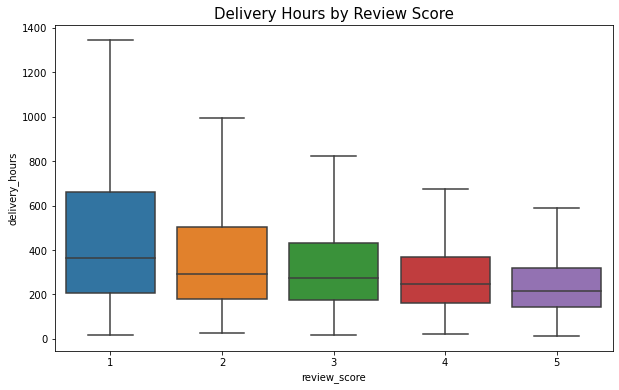

In [1847]:
df['delivery_time'] = df['order_delivered_customer_date'] - df['order_approved_at']
df['delivery_hours'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('delivery_hours > 0') 

df['delivery_time'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']
df['expect_diff'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))

df['delivery_time'] = df['order_delivered_carrier_date'] - df['order_approved_at']
df['until_shipped'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('until_shipped > 0') 

df['delivery_time'] = df['order_delivered_customer_date'] - df['order_delivered_carrier_date']
df['ship_hour'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('ship_hour > 0') 

plt.figure(figsize =(10,6))
sns.boxplot(df['review_score'], df['delivery_hours'], showfliers = False)
plt.title("Delivery Hours by Review Score", size = 15);

<AxesSubplot:xlabel='review_score', ylabel='expect_diff'>

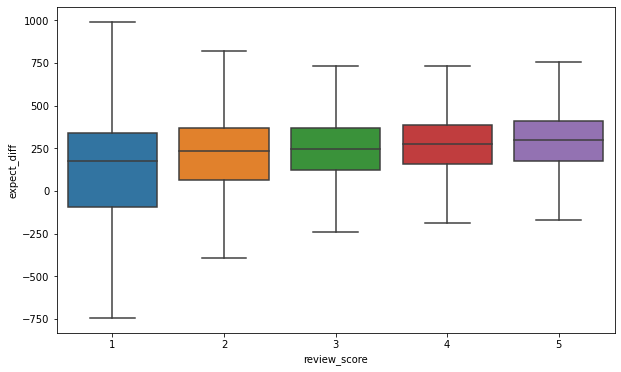

In [1848]:
plt.figure(figsize =(10,6))
sns.boxplot(df['review_score'], df['expect_diff'], showfliers = False)

<AxesSubplot:xlabel='review_score', ylabel='until_shipped'>

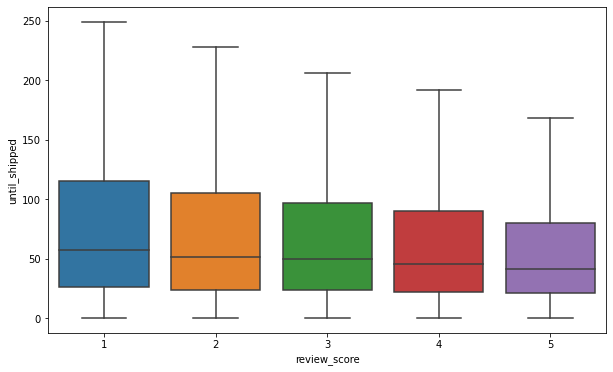

In [1849]:
plt.figure(figsize =(10,6))
sns.boxplot(df['review_score'], df['until_shipped'], showfliers = False)

<AxesSubplot:xlabel='review_score', ylabel='ship_hour'>

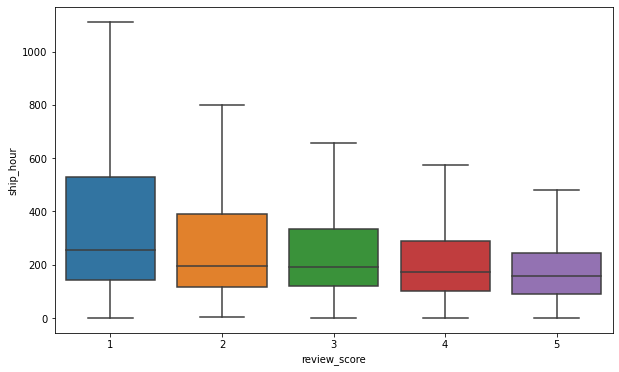

In [1850]:
plt.figure(figsize =(10,6))
sns.boxplot(df['review_score'], df['ship_hour'], showfliers = False)

In [1851]:
df.groupby(['product_category'])['review_score'].mean().sort_values(ascending = False).head(10)

product_category
fashion_childrens_clothes                5.000000
cds_dvds_musicals                        4.642857
books_general_interest                   4.495274
books_imported                           4.490909
costruction_tools_tools                  4.392157
books_technical                          4.382812
fashion_sport                            4.344828
food_drink                               4.342007
luggage_accessories                      4.321495
small_appliances_home_oven_and_coffee    4.319444
Name: review_score, dtype: float64

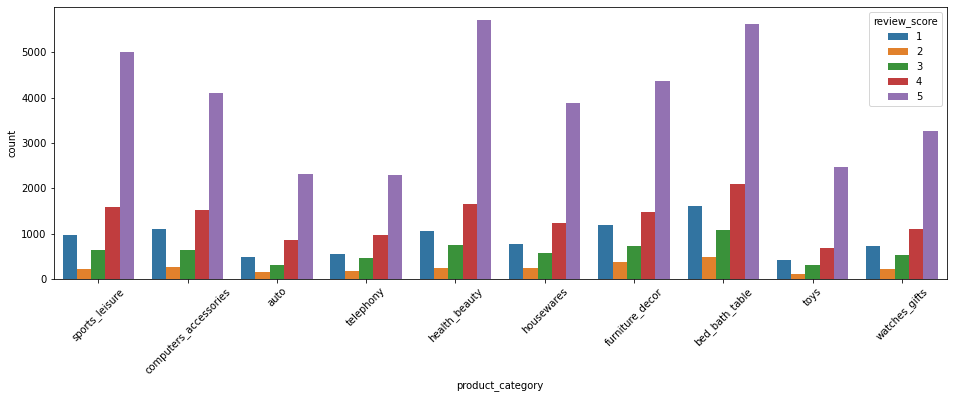

In [1852]:
cat_lists = ['bed_bath_table', 'telephony','furniture_decor','computers_accessories','watches_gifts','auto','housewares',
'health_beauty', 'toys','sports_leisure']
df_top10 = df[df['product_category'].isin(cat_lists)]

plt.figure(figsize = (16,5))
sns.countplot(df_top10['product_category'], hue = df_top10['review_score'])
plt.xticks(rotation = 45);

In [1853]:
df.groupby(['product_category'])['review_score'].std().sort_values(ascending = False)

product_category
security_and_services        2.121320
la_cuisine                   1.847184
home_comfort_2               1.751518
fashion_male_clothing        1.673850
party_supplies               1.586209
                               ...   
food_drink                   1.103819
books_general_interest       1.053708
fashion_sport                1.009804
cds_dvds_musicals            0.633324
fashion_childrens_clothes    0.000000
Name: review_score, Length: 72, dtype: float64

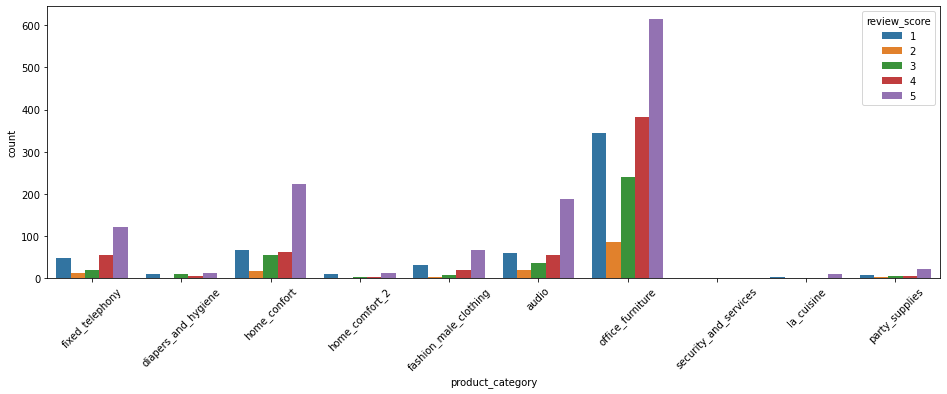

In [1854]:
df_bottom_10_mean = df.groupby(['product_category'])['review_score'].mean().sort_values(ascending = True)[:10]
df_bottom_mean = df[df['product_category'].isin(df_bottom_10_mean.index)]
plt.figure(figsize = (16,5))
sns.countplot(df_bottom_mean['product_category'], hue =  df_bottom_mean['review_score'])
plt.xticks(rotation = 45);

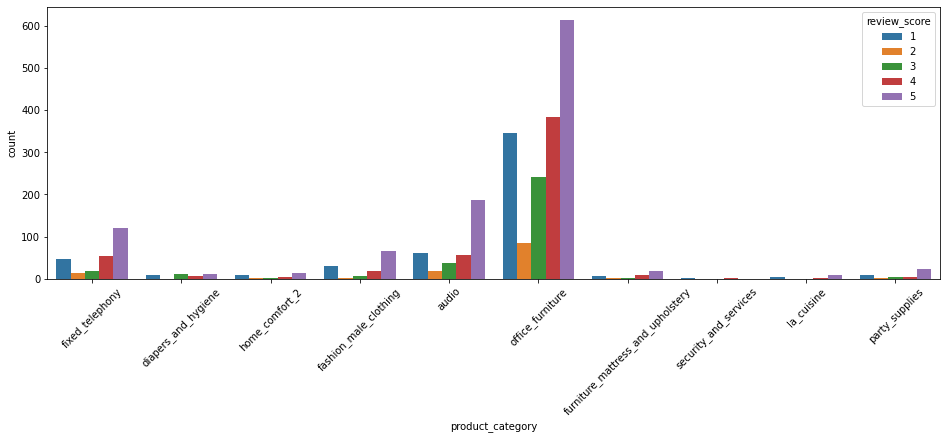

In [1855]:
df_bottom_10_std = df.groupby(['product_category'])['review_score'].std().sort_values(ascending = False)[:10]

df_bottom_std = df[df['product_category'].isin(df_bottom_10_std.index)]
plt.figure(figsize = (16,5))
sns.countplot(df_bottom_std['product_category'], hue =  df_bottom_std['review_score'])
plt.xticks(rotation = 45);

In [1856]:
df.groupby(['payment_type'])['review_score'].agg(['mean', 'std'])

,mean,std
payment_type,,
boleto,4.036707,1.375840
credit_card,4.041398,1.379713
debit_card,4.177518,1.297650
voucher,4.020841,1.399365


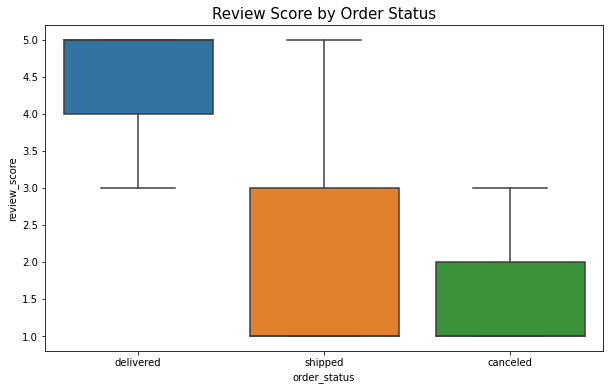

In [1857]:
plt.figure(figsize =(10,6))
sns.boxplot(df['order_status'], df['review_score'], showfliers = False)
plt.title("Review Score by Order Status", size = 15);

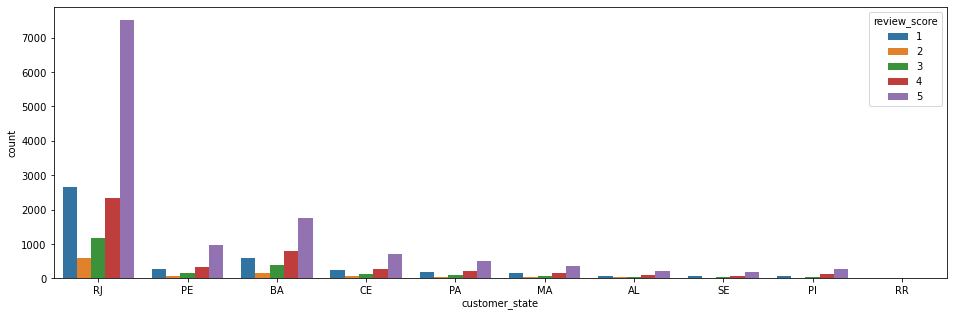

In [1858]:
# 최고, 최저 평점 편차가 큰 주들

df_bottom_10_std = df.groupby(['customer_state'])['review_score'].std().sort_values(ascending = False)[:10]
df_bottom_std = df[df['customer_state'].isin(df_bottom_10_std.index)]
plt.figure(figsize = (16,5))
sns.countplot(df_bottom_std['customer_state'], hue =  df_bottom_std['review_score']);

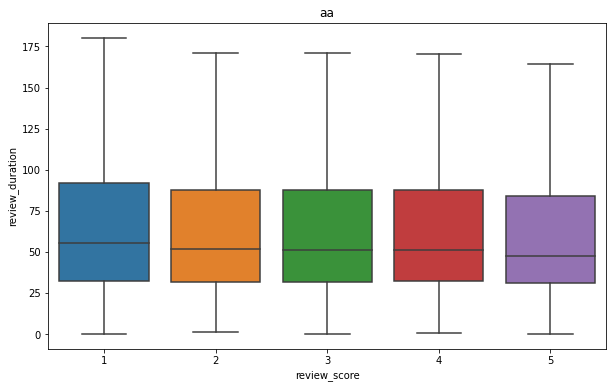

In [1859]:
df['review_duration'] = df['review_answer_timestamp'] - df['order_delivered_customer_date']
df['review_duration'] = df['review_duration'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('review_duration > 0') 

plt.figure(figsize = (10,6))
sns.boxplot(df['review_score'], df['review_duration'], showfliers = False)
plt.title('aa');

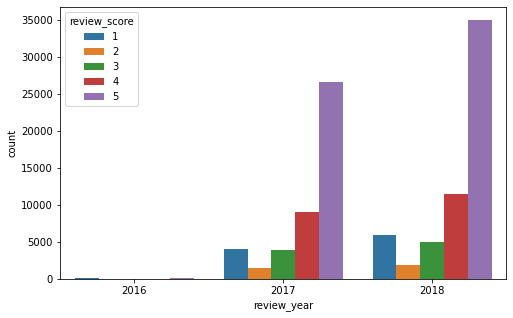

In [1860]:
df['review_year'] = df['review_answer_timestamp'].dt.year
df['review_month'] = df['review_answer_timestamp'].dt.month
df['review_dayofweek'] = df['review_answer_timestamp'].dt.dayofweek
df['review_day'] = df['review_answer_timestamp'].dt.day
df['review_hour'] = df['review_answer_timestamp'].dt.hour
df['purchase_year'] = df['order_purchase_timestamp'].dt.year
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
df['purchase_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek
df['purchase_day'] = df['order_purchase_timestamp'].dt.day
df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour

plt.figure(figsize = (8,5))
sns.countplot(df['review_year'], hue =  df['review_score']);

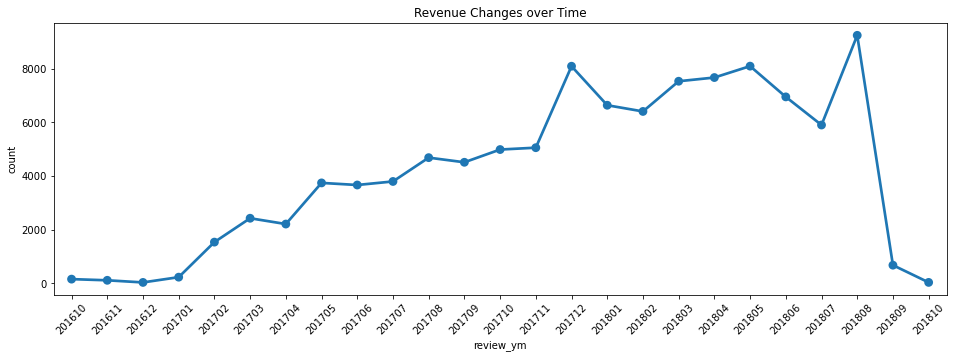

In [1861]:
# 그 이유는 주문 제품수의 폭주

df['review_month'] = df.review_month.map("{:02}".format)
df['review_year'] = df.review_year.map("{:02}".format)
df['review_ym'] = df['review_year'].astype(str) + df['review_month'].astype(str)

df_ym = df.groupby('review_ym').size().reset_index(name = 'count')
plt.figure(figsize = (16,5))
sns.pointplot(df_ym['review_ym'], df_ym['count'])
plt.xticks(rotation = 45)
plt.title('Revenue Changes over Time');

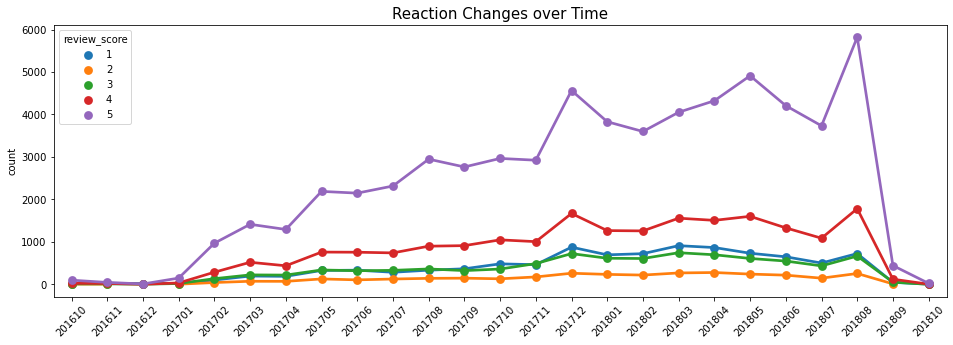

In [1862]:
review_ym = df.groupby(['review_ym','review_score']).size().reset_index(name = 'count')
plt.figure(figsize = (16,5))
ax = sns.pointplot(data= review_ym, x = 'review_ym', y = 'count', hue = 'review_score')
plt.xticks(rotation = 45)
plt.xlabel(None)
plt.title("Reaction Changes over Time", size = 15);

In [1863]:
# 요일 분석

df.groupby(['review_dayofweek'])['review_score'].mean()

review_dayofweek
0    4.113877
1    4.140194
2    4.160411
3    4.171411
4    4.177454
5    4.189567
6    4.156633
Name: review_score, dtype: float64

In [1864]:
# 월초,월말 (1주와 4,5주 차이에 주목)

df['week_num'] = np.ceil(df['review_day']/7)
df.groupby(['week_num'])['review_score'].mean()

week_num
1.0    4.164089
2.0    4.162665
3.0    4.153699
4.0    4.159810
5.0    4.147842
Name: review_score, dtype: float64

In [1865]:
df.groupby('review_month')['review_score'].mean()
# 따뜻한 날씨에 더 관대해짐 (5월에서 10월)

review_month
01    4.103363
02    4.104091
03    4.049493
04    4.084185
05    4.188144
06    4.178000
07    4.245232
08    4.270150
09    4.245134
10    4.179220
11    4.122654
12    4.079109
Name: review_score, dtype: float64

In [1866]:
df.groupby('review_day')['review_score'].mean() # 패턴 없음

review_day
1     4.221917
2     4.162358
3     4.126959
4     4.133020
5     4.145224
6     4.160081
7     4.202304
8     4.143335
9     4.177999
10    4.188945
11    4.142567
12    4.146424
13    4.178720
14    4.159718
15    4.142273
16    4.173352
17    4.169622
18    4.148008
19    4.114865
20    4.148603
21    4.176363
22    4.121271
23    4.146265
24    4.175728
25    4.176028
26    4.160507
27    4.163413
28    4.175913
29    4.162614
30    4.171932
31    4.087793
Name: review_score, dtype: float64

In [1867]:
df.groupby('review_hour')['review_score'].mean()
# 밤시간에 더 관대해짐 (17시부터 새벽 2시까지)

review_hour
0     4.216084
1     4.215023
2     4.202848
3     4.182222
4     4.054029
5     3.956600
6     4.087264
7     4.178241
8     4.166346
9     4.137996
10    4.121800
11    4.144236
12    4.049810
13    4.115081
14    4.128055
15    4.089477
16    4.115818
17    4.199779
18    4.152211
19    4.124507
20    4.174583
21    4.237724
22    4.180401
23    4.233998
Name: review_score, dtype: float64

In [1868]:
total = df.groupby('order_id').order_item_id.max().reset_index()
total.columns = ['order_id', 'total_count']
df = pd.merge(df, total, on = 'order_id')
# 이번 주문에서 몇개 아이템 주문

In [1869]:
df.groupby('total_count')['review_score'].mean()

total_count
1     4.301943
2     3.732328
3     3.560510
4     3.418259
5     3.500000
6     3.443820
7     2.809524
8     4.000000
9     3.000000
10    2.250000
11    2.750000
12    3.000000
13    3.000000
14    1.000000
15    5.000000
20    1.000000
Name: review_score, dtype: float64

In [1870]:
# returning customer?

df['purchase_month'] = df.purchase_month.map("{:02}".format)
df['purchase_year'] = df.purchase_year.map("{:02}".format)
df['purchase_day'] = df.purchase_day.map("{:02}".format)
df['purchase_ym'] = df['purchase_year'].astype(str) + df['purchase_month'].astype(str)

df['order_purchase_date'] = df['purchase_year'].astype(str) + df['purchase_month'].astype(str) + df['purchase_day'].astype(str)
min_purchase = df.groupby('customer_unique_id').order_purchase_date.min().reset_index()
min_purchase.columns = ['customer_unique_id', 'min_timestamp']
df = pd.merge(df, min_purchase, on = 'customer_unique_id')
df['usertype'] = 'New'
df.loc[df['order_purchase_date']>df['min_timestamp'], 'usertype'] = 'Existing'

In [1871]:
df.groupby('usertype')['review_score'].mean()

usertype
Existing    4.311163
New         4.155138
Name: review_score, dtype: float64

In [1872]:
# repurchase?

first_purchase = df.groupby(['customer_unique_id', 'product_id']).order_purchase_date.min().reset_index()
first_purchase.columns = ['customer_unique_id', 'product_id', 'min_purchase_date']
df = pd.merge(df, first_purchase, on = ['customer_unique_id', 'product_id'])
df['repurchase'] = 'first'
df.loc[df['order_purchase_date']>df['min_purchase_date'], 'repurchase'] = 'second+'

In [1873]:
df.groupby('repurchase')['review_score'].mean()

repurchase
first      4.158759
second+    4.213270
Name: review_score, dtype: float64

<AxesSubplot:xlabel='repurchase', ylabel='review_score'>

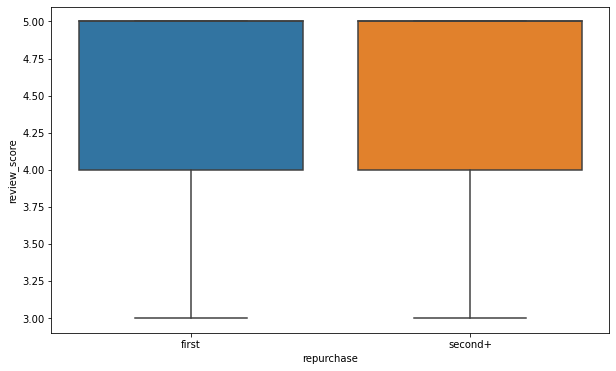

In [1874]:
plt.figure(figsize = (10,6))
sns.boxplot(df['repurchase'], df['review_score'], showfliers = False)

<AxesSubplot:xlabel='usertype', ylabel='review_score'>

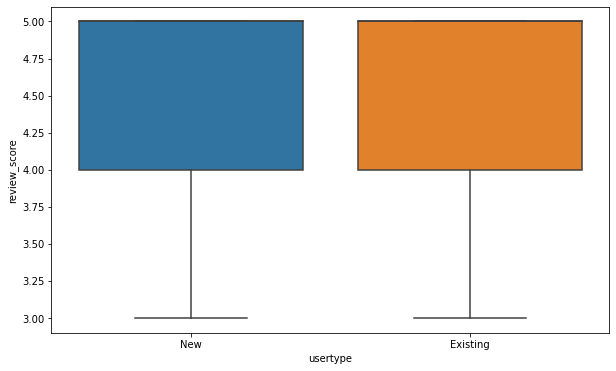

In [1875]:
plt.figure(figsize = (10,6))
sns.boxplot(df['usertype'], df['review_score'], showfliers = False)

# 평균으로 볼때는 차이가 있는데 표로 보니 차이가 없을때 넣어야 하나? (usertype, repurchase) 평균, 표 어떤것을 우선시?
# 평균으로 볼때 트렌드가 보여서 넣었는데 점수가 떨어질 때 (동시에 시키는 물건 수)
# 표로 볼때 트렌드가 보여서 넣었는데 점수가 떨어질 때 (ship hour)
# 다른 변수와 완전 중복되는 내용이라 안넣었는데 점수가 떨어질 때 넣어야하나? (ad와 proudct description)
# seller_id와 product_id를 feature로 넣고 싶은데 차원축소 해야하나?
# x가 연속형인 변수의 그래프 그리는 법?
# 아예 낮은 F1은 변수 선택을 잘못한건가???
# 피쳐 아이디어!!

In [1876]:
total_f = df.groupby('order_id')['freight_value'].sum().reset_index()
total_f.columns = ['order_id', 'total_freight']
df = pd.merge(df, total_f, on = 'order_id')
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,...,review_ym,week_num,total_count,purchase_ym,order_purchase_date,min_timestamp,usertype,min_purchase_date,repurchase,total_freight
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NA,NA,2018-01-18,2018-01-18 21:46:59,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,201801,3.0,2,201801,20180111,20180111,New,20180111,first,27.26
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NA,NA,2018-01-18,2018-01-18 21:46:59,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,201801,3.0,2,201801,20180111,20180111,New,20180111,first,27.26
2,e2655da8bccce2ddc2f43cc2c80d24f3,19721d59a9764437477eff0730b48665,5,NA,NA,2018-04-10,2018-04-11 11:30:43,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,201804,2.0,1,201803,20180326,20180326,New,20180326,first,20.26
3,cb18f53b563f0bdeb76be0376ddd6b6a,efd626e6a12a82d76e456e34093f8356,5,NA,NA,2017-12-28,2017-12-30 12:07:50,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,201712,5.0,1,201712,20171207,20170829,Existing,20171207,first,17.05
4,cedaa544c02177d542776d45bdccd9eb,8a667bf7baec5286ad76d81facdc85e5,5,NA,NA,2017-09-06,2017-09-08 17:00:43,1,a4fdd00347db855f614a18bf51606df5,6d803cb79cc31c41c4c789a75933b3c7,...,201709,2.0,1,201708,20170829,20170829,New,20170829,first,13.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104411,f67e51de7cb2234e049746605fac5e45,8c1d27c10cc60cc369a428813bb71350,4,recomendo,otimo produto,2018-07-31,2018-08-08 04:46:21,1,9680a78df870a1cb6ae00cb3436fe06a,a72f15980dc3e9bfd1a49ac9b2f3af65,...,201808,2.0,1,201807,20180725,20180725,New,20180725,first,18.73
104412,4c3a0a71949616a4e151dc0b6cf46813,80ba449ea98f8e879a829759b5a66294,5,NA,NA,2018-03-13,2018-03-13 20:53:09,1,cec29a60285cd686caa31318b3ad3671,ede2977fbaf3738583170735ca403f6c,...,201803,2.0,1,201802,20180225,20180225,New,20180225,first,37.35
104413,594f48f0f7a3d8ed2f1794cfb16dbc4c,5fd71cc4eb69ae6f65ac3acfcbc17ab5,5,NA,NA,2018-03-29,2018-03-30 00:41:37,1,d057ce621bd15258809e3c0768badd1c,dcb7367a92f5ffb89f1e2152ed260285,...,201803,5.0,1,201803,20180318,20180318,New,20180318,first,18.44
104414,3d6af3d16d8ad6c987f43e9a10f9f46b,61d5f1dcdf9b023ea7622b65d2362e4f,1,NA,Aguardo a devolução do produto pois o mesmo ve...,2018-04-12,2018-04-13 19:29:00,1,496b2ebd2cc9b8b262c9705b1f3589ea,61c36f0fc4a47f9532e5512b66668e62,...,201804,2.0,1,201803,20180330,20180330,New,20180330,first,17.69


In [1877]:
df['same_region'] = df.apply(lambda row: "Same" if row['customer_state'] == row['seller_state'] else "Different", axis = 1)

In [1878]:
df.groupby('same_region')['review_score'].mean()

same_region
Different    4.116524
Same         4.231775
Name: review_score, dtype: float64

In [1879]:
df['ad'] = df['product_photos_qty'] + df['product_description_lenght']

In [1880]:
# 이전 주문까지로 바꾸기

seller_score = df.groupby('seller_id')['review_score'].mean().reset_index()
seller_score.columns = ['seller_id', 'seller_score']
df = pd.merge(df, seller_score, on = 'seller_id')

In [1881]:
# 이전 주문까지로 바꾸기

seller_count = df.groupby('seller_id')['order_id'].count().reset_index()
seller_count.columns = ['seller_id', 'seller_count']
df = pd.merge(df, seller_count, on = 'seller_id')

In [1882]:
# 이전 주문까지로 바꾸기 

user_score = df.groupby('customer_unique_id')['review_score'].mean().reset_index()
user_score.columns = ['customer_unique_id', 'user_score']
df = pd.merge(df, user_score, on = 'customer_unique_id')

In [1704]:
# 이전 주문까지로 바꾸기

user_count = df.groupby('customer_unique_id')['order_id'].count().reset_index()
user_count.columns = ['customer_unique_id', 'user_count']
df = pd.merge(df, user_count, on = 'customer_unique_id')

In [ ]:
# 한 주문에서 같은 물건을 몇개 시켰나?



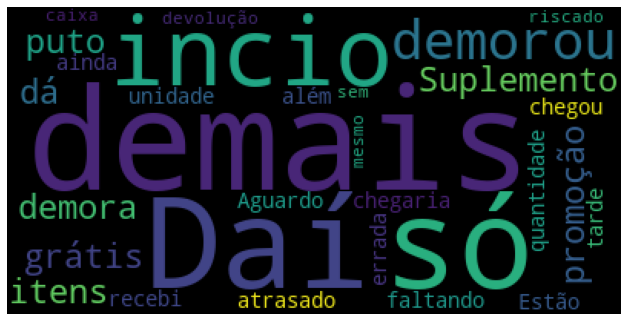

In [1725]:
stopwords = {'para', 'mas', 'do', 'e', 'em','um','dezembro','produtos', 'uma', 'todos', "NA'",'lado', 'estou', 'pra', 'ou','de', 'o', 'a', 'no', 'nan', 'Quero', 'ate','os','NA',
             'quase', 'produto','vieram','aqui', 'veio', 'mes', 'so', 'ano', 'eu', 'un', 'dizer', "un'",'acabou', 'contudo','outro', 'nQuer','pois','chegar','passado', "outro'",
            'unidades', 'hoje', 'r', 'n', 'comprei', 'que', 'apos', 'mais', 'apos', 'tive', 'com', 'meu', 'q', 'boa', 'fizerao', 'isso', 'dele', 'mim', '200g', 'vida', 'compra',
            'lannister', 'seja', 'aumentei', 'valor', 'universal', 'creatina'}

below_3 = df[df['review_score']<3]
text = below_3['review_comment_message'].values
wordcloud = WordCloud(stopwords=stopwords)
wordcloud = wordcloud.generate(str(text))
plt.figure(figsize = (11,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 한 주문에서 같은 물건을 몇개 시켰나. 

발송 오류 (필요한게 안오거나 잘못 옴): quantitade, unidade (amount), errada (wrong), recebi/recebo (I received), direoto (right), sem (lack) - seller_id, 동시에 시키는 물건 수

배송 지연: entrega (delivery), correio (post), frete (freight), chegou (has arrived), sem (week), tarde (late), nAguardo (I wait) - 배송 시간, 지역 차이

상품 하자 or 과장광고: conforto (comfort), enganosa (misleading), riscado (damaged), propaganda - product_id. 상품 재구매 여부

특정 제품 카테고리: boneca (doll), capa, catruchos (catridges), bebe, carro (car) - 카테고리


paguei (I paid), dinheiro (money), retirar (refund), devolucao (refund)
tentando: trying
prazo: deadline
solucao: solution
apenas: only

### Classification

In [ ]:
df.info()

In [1707]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104416 entries, 0 to 104415
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_item_id               104416 non-null  int64  
 1   price                       104416 non-null  float64
 2   product_description_lenght  104416 non-null  float64
 3   order_status                104416 non-null  object 
 4   payment_type                104416 non-null  object 
 5   payment_value               104416 non-null  float64
 6   customer_state              104416 non-null  object 
 7   seller_state                104416 non-null  object 
 8   product_category            104416 non-null  object 
 9   delivery_hours              104416 non-null  float64
 10  expect_diff                 104416 non-null  float64
 11  until_shipped               104416 non-null  float64
 12  ship_hour                   104416 non-null  float64
 13  review_duratio

In [ ]:
# df_model = df.drop(columns = ['product_id','review_id','seller_id', 'order_id', 'shipping_limit_date', 'review_score', 'review_creation_date', 'order_purchase_timestamp',
#                               'order_approved_at', 'customer_id', 'order_delivered_carrier_date','min_purchase_date','review_answer_timestamp',
#                               'product_height_cm','product_length_cm','product_width_cm','product_name_lenght','review_dayofweek','customer_zip_code_prefix',
#                              'order_delivered_customer_date', 'customer_unique_id', 'reaction', 'order_purchase_date', 'min_timestamp','product_weight_g','seller_zip_code_prefix',
#                                'review_comment_title', 'review_comment_message','delivery_time','customer_city','review_month','freight_value','ad',
#                               'product_photos_qty','same_region', 'payment_installments', 'payment_sequential', 'purchase_dayofweek', 'purchase_day', 'purchase_hour', 'seller_city', 'order_estimated_delivery_date']
                

In [1774]:
df_model = df.drop(columns = ['product_id','review_id','seller_id', 'order_id', 'shipping_limit_date', 'review_score', 'review_creation_date', 'order_purchase_timestamp',
                              'order_approved_at', 'customer_id', 'order_delivered_carrier_date','min_purchase_date','review_answer_timestamp',
                              'product_height_cm','product_length_cm','product_width_cm','product_name_lenght','review_dayofweek','customer_zip_code_prefix',
                             'order_delivered_customer_date', 'customer_unique_id', 'reaction', 'order_purchase_date', 'min_timestamp','product_weight_g','seller_zip_code_prefix',
                               'review_comment_title', 'review_comment_message','delivery_time','customer_city','review_month','freight_value','ad','user_score',
                              'product_photos_qty','same_region', 'payment_installments', 'payment_sequential', 'purchase_dayofweek', 'purchase_day', 'purchase_hour', 'seller_city', 'order_estimated_delivery_date'])
                
df_model.head()

,order_item_id,price,product_description_lenght,order_status,payment_type,payment_value,customer_state,seller_state,product_category,delivery_hours,...,review_ym,week_num,total_count,purchase_ym,usertype,repurchase,total_freight,seller_score,seller_count,user_count
0,1,185.0,858.0,delivered,credit_card,397.26,SP,SP,sports_leisure,146.911667,...,201801,3.0,2,201801,New,first,27.26,4.444444,63,2
1,2,185.0,858.0,delivered,credit_card,397.26,SP,SP,sports_leisure,146.911667,...,201801,3.0,2,201801,New,first,27.26,4.444444,63,2
2,1,185.0,858.0,delivered,credit_card,205.26,RS,SP,sports_leisure,346.629167,...,201804,2.0,1,201803,New,first,20.26,4.444444,63,1
3,1,185.0,858.0,delivered,credit_card,202.05,MG,SP,sports_leisure,477.480000,...,201712,5.0,1,201712,Existing,first,17.05,4.444444,63,2
4,1,179.9,772.0,delivered,credit_card,193.50,SP,SP,sports_leisure,174.961111,...,201709,2.0,1,201708,New,first,13.60,4.444444,63,2


In [1775]:
# label encoder preparation

# for column in df_model:
#     if df_model[column].isna().sum() != 0:
#         df_model[column] = df_model[column].dropna()
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
    
# c = df_model.columns[df_model.dtypes == 'object']

# for i in c:
#     df_model[i] = le.fit_transform(df_model[i])

In [1776]:
c = df_model.columns[df_model.dtypes == 'object']

df_model = pd.get_dummies(df_model, columns = c)

In [1777]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_model = scaler.fit_transform(df_model)

In [1778]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_model, df['reaction'], test_size = 0.2, random_state = 100)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 100)
x_train.shape, x_valid.shape, x_test.shape

((66825, 215), (16707, 215), (20884, 215))

In [1779]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)
x_valid_s = scaler.transform(x_valid)

In [1780]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(verbose = 100) #3000번
cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=50)

Learning rate set to 0.089468
0:	learn: 0.6495441	test: 0.6497019	best: 0.6497019 (0)	total: 15.9ms	remaining: 15.9s
100:	learn: 0.4416996	test: 0.4488711	best: 0.4488711 (100)	total: 1.43s	remaining: 12.7s
200:	learn: 0.4264915	test: 0.4425097	best: 0.4425097 (200)	total: 2.91s	remaining: 11.6s
300:	learn: 0.4141170	test: 0.4392386	best: 0.4392255 (299)	total: 4.34s	remaining: 10.1s
400:	learn: 0.4032091	test: 0.4369778	best: 0.4369608 (396)	total: 5.76s	remaining: 8.6s
500:	learn: 0.3929156	test: 0.4345983	best: 0.4345983 (500)	total: 7.19s	remaining: 7.16s
600:	learn: 0.3833416	test: 0.4333156	best: 0.4333099 (597)	total: 8.56s	remaining: 5.68s
700:	learn: 0.3747013	test: 0.4323846	best: 0.4323589 (698)	total: 9.98s	remaining: 4.26s
800:	learn: 0.3669691	test: 0.4310651	best: 0.4310651 (800)	total: 11.4s	remaining: 2.84s
900:	learn: 0.3589637	test: 0.4304544	best: 0.4303452 (876)	total: 12.9s	remaining: 1.41s
999:	learn: 0.3518781	test: 0.4295357	best: 0.4295357 (999)	total: 14.2s	r

In [1781]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
result_classifier_test = cbc.predict(x_test)
f1 = f1_score(y_test, result_classifier_test)
cr = classification_report(y_test, result_classifier_test)
cm = confusion_matrix(y_test, result_classifier_test)

In [1782]:
f1 #3842

0.38229166666666664

In [1888]:
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16518
           1       0.79      0.25      0.38      4366

    accuracy                           0.83     20884
   macro avg       0.81      0.62      0.64     20884
weighted avg       0.82      0.83      0.79     20884



In [791]:
cm

array([[16216,   221],
       [ 3527,   920]], dtype=int64)

In [492]:
from sklearn.metrics import log_loss
ll = log_loss(y_test, cbc.predict_proba(x_test))
ll

0.44967869412359235

In [496]:
from sklearn.model_selection import StratifiedKFold  
skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state = 42)

result_cv = 0

for train_index, valid_index in skf.split(x_train, y_train): 
    xx_train = x_train.iloc[train_index]
    xx_valid = x_train.iloc[valid_index]
    yy_train = y_train.iloc[train_index]
    yy_valid = y_train.iloc[valid_index]
    cbc_cv = CatBoostClassifier(verbose = 100)
    cbc_cv.fit(xx_train, yy_train, eval_set=(xx_valid, yy_valid), early_stopping_rounds=50)
    result_cv+=cbc_cv.predict_proba(x_test)/2

Learning rate set to 0.083212
0:	learn: 0.6532625	test: 0.6534830	best: 0.6534830 (0)	total: 21.8ms	remaining: 21.8s
100:	learn: 0.4501956	test: 0.4596353	best: 0.4596071 (99)	total: 1.23s	remaining: 10.9s
200:	learn: 0.4375888	test: 0.4567522	best: 0.4567522 (200)	total: 2.41s	remaining: 9.59s
300:	learn: 0.4269204	test: 0.4558716	best: 0.4557963 (290)	total: 3.6s	remaining: 8.35s
400:	learn: 0.4174541	test: 0.4556057	best: 0.4555330 (385)	total: 4.82s	remaining: 7.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.455533022
bestIteration = 385

Shrink model to first 386 iterations.
Learning rate set to 0.083212
0:	learn: 0.6534621	test: 0.6532476	best: 0.6532476 (0)	total: 20.7ms	remaining: 20.7s
100:	learn: 0.4513501	test: 0.4554388	best: 0.4554388 (100)	total: 1.24s	remaining: 11.1s
200:	learn: 0.4390772	test: 0.4519996	best: 0.4519996 (200)	total: 2.4s	remaining: 9.54s
300:	learn: 0.4288767	test: 0.4507910	best: 0.4507910 (300)	total: 3.53s	remaining: 8.21s
400

In [792]:
f1 = f1_score(y_test, result_cv.argmax(1)) 
cr = classification_report(y_test, result_cv.argmax(1))
cm = confusion_matrix(y_test, result_cv.argmax(1))

ValueError: Found input variables with inconsistent numbers of samples: [20884, 19465]

In [794]:
f1

0.32927702219040805

In [795]:
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16437
           1       0.81      0.21      0.33      4447

    accuracy                           0.82     20884
   macro avg       0.81      0.60      0.61     20884
weighted avg       0.82      0.82      0.78     20884



In [796]:
cm

array([[16216,   221],
       [ 3527,   920]], dtype=int64)

In [797]:
cbc.feature_importances_
pd.Series(cbc.feature_importances_, index = x_train.columns).sort_values(ascending = False).head(20)

total_count                        9.593619
expect_diff                        6.990683
review_duration                    6.724251
delivery_hours                     6.595401
total_freight                      6.521773
until_shipped                      6.138230
price                              5.936836
product_description_lenght         5.738759
ship_hour                          5.443199
payment_value                      4.960575
review_hour                        3.469491
order_status_shipped               1.292443
seller_state_SP                    0.735005
customer_state_RJ                  0.688657
order_status_delivered             0.631325
product_category_bed_bath_table    0.535862
product_category_garden_tools      0.475199
product_category_sports_leisure    0.474548
customer_state_MG                  0.474156
product_category_stationery        0.451484
dtype: float64

In [289]:
from eli5.sklearn import PermutationImportance
import eli5

permutation = PermutationImportance(cbc).fit(x_valid, y_valid) 
eli5.show_weights(permutation, feature_names = x_valid.columns.tolist()) 

KeyboardInterrupt: 

### Conclusion & Action Plan